In [1]:
import os, tempfile
import logging

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        #sakakibara_inact_kin_100,
                                        #sakakibara_inact_kin_80,
                                        sakakibara_rec)
from experiments.ina_schneider import (schneider_taum)

In [5]:
modelfile = 'models/courtemanche_ina.mmt'

# M gate -> only activation steady-state and tau_m

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                #sakakibara_inact,
                                                #sakakibara_inact_kin_1,
                                                #sakakibara_inact_kin_100,
                                                #sakakibara_inact_kin_80,
                                                #sakakibara_rec,
                                                schneider_taum)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

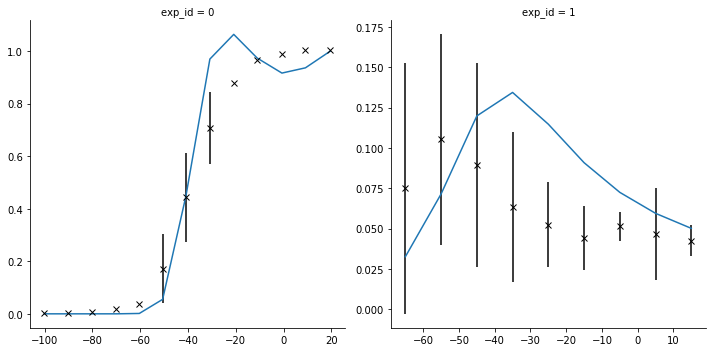

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     #sakakibara_inact,
                     #sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_inact_kin_80,
                     #sakakibara_rec,
                     schneider_taum)

In [9]:
limits = {'ina.a1_m': (-100, 0),
          'ina.a2_m': (0, 1),
          'ina.a3_m': (0, 1),
          'ina.a4_m': (0, 10),
          'ina.b1_m': (0, 10),
          'ina.b2_m': (0, 100)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_mgate_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [14]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5570757359362264, '1': 1.5570757359362264, '2': 1.5570757359362264, '3': 1.5570757359362264, '4': 1.5570757359362264, '5': 0.5904911622959486, '6': 0.45939980914873735, '7': 0.5710013425594168, '8': 1.5570757359362264, '9': 1.5570757359362264, '10': 1.5570757359362264, '11': 1.5570757359362264, '12': 1.5570757359362264, '13': 0.15235445469736852, '14': 0.1819349064747563, '15': 0.1879980741832115, '16': 0.25507625823484376, '17': 0.4491978085688121, '18': 0.5936989296806218, '19': 1.3185718986681156, '20': 0.4160669679218102, '21': 1.2534510282040947}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [15]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [16]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-23 17:07:35.760566, end_time=None)>


In [17]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 996
DEBUG:Epsilon:new eps, t=1, eps=1.0311347633808372
INFO:ABC:t:1 eps:1.0311347633808372
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 2026
DEBUG:Epsilon:new eps, t=2, eps=0.7597488221321739
INFO:ABC:t:2 eps:0.7597488221321739
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 3194
DEBUG:Epsilon:new eps, t=3, eps=0.6487851633963204
INFO:ABC:t:3 eps:0.6487851633963204
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 4462
DEBUG:Epsilon:new eps, t=4, eps=0.5598610116739912
INFO:ABC:t:4 eps:0.5598610116739912
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 5809
DEBUG:Epsilon:new eps, t=5, eps=0.49570040317337

### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution(m=0)

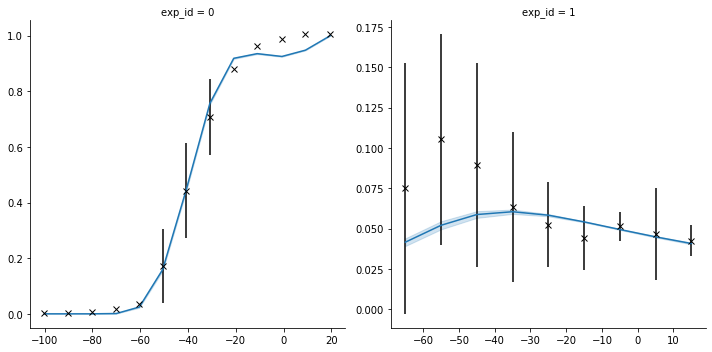

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     #sakakibara_inact,
                     #sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_rec100,
                     schneider_taum,
                     df=df, w=w)

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

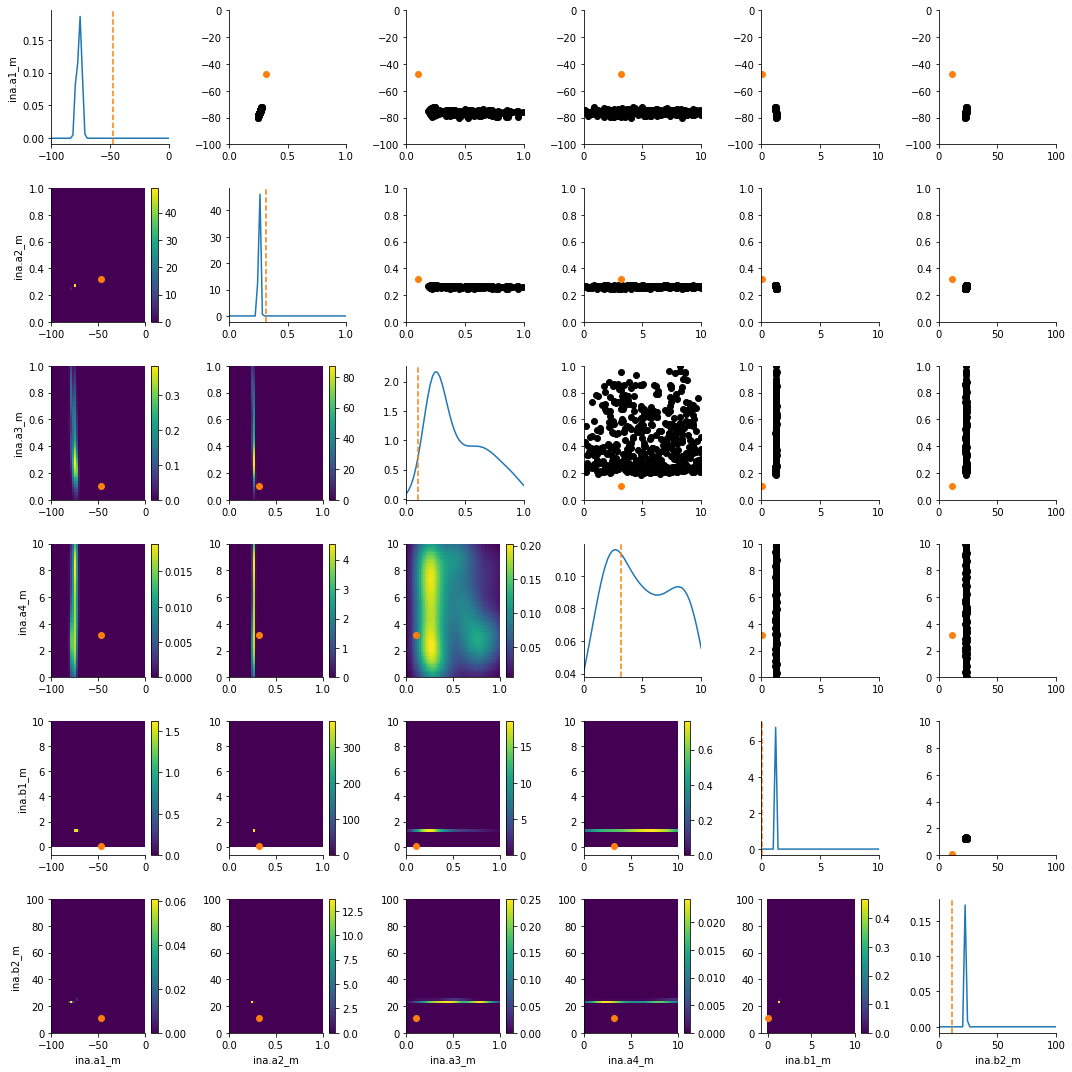

In [25]:
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# H gate -> Only SS inactivation and tau_h

In [26]:
observations, model, summary_statistics = setup(modelfile,
                                                #sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,
                                                #sakakibara_inact_kin_100,
                                                #sakakibara_inact_kin_80,
                                                sakakibara_rec)
                                                #schneider_taum)

In [27]:
assert len(observations)==len(summary_statistics(model({})))

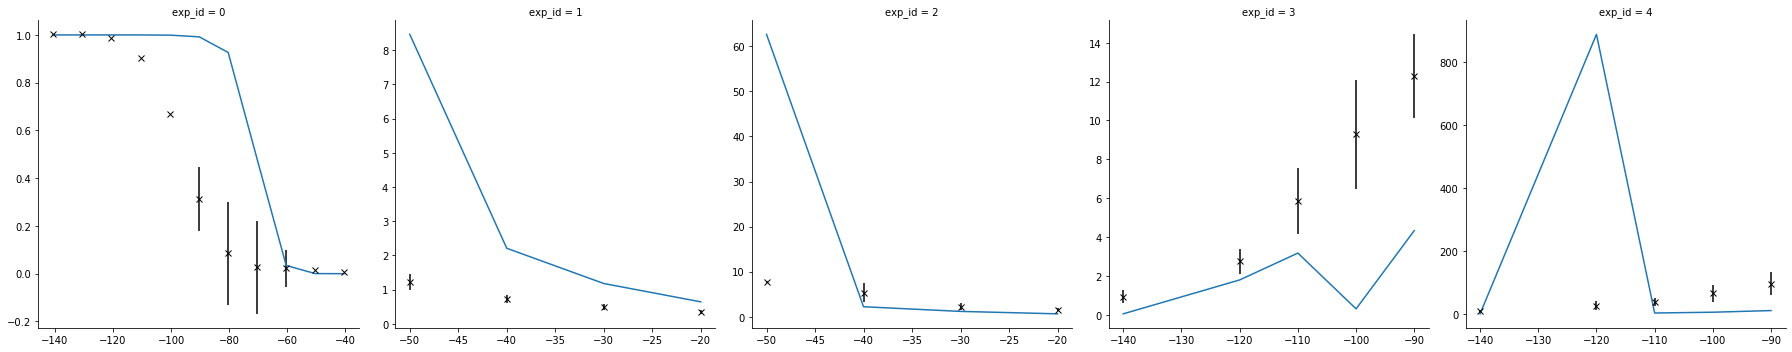

In [28]:
g = plot_sim_results(modelfile,
                     #sakakibara_act,
                     sakakibara_inact,
                     sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_inact_kin_80,
                     sakakibara_rec)
                     #schneider_taum)